In [2]:
import numpy as np

# test sample data
Nsamples = 10000
batch_size = 64
Ndims = 10
noise = 0.1

np.random.seed(1337)
samples = np.random.uniform(-1., 1., size=(Nsamples, Ndims))
samples = np.float32(samples)
y = np.zeros(Nsamples)
# Make some random coefficients negative
#coefficients[:2] *= -1
# coefficients[5] *= -1
# coefficients[8:] *= -1
# Scale the coefficients differently
coefficients = np.random.uniform(-1, 1, size=Ndims)
coefficients = np.float32(coefficients)
# calculate the product
for i, x in enumerate(samples):
    y[i] = np.sum(coefficients*x)+np.random.normal(0, noise)

y = np.float32(y)
print(samples)
print(coefficients)
print(y)

# Save samples and y to CSV
np.savetxt('data.csv', np.column_stack((samples, y)), delimiter=',', fmt='%1.6f')
np.savetxt('coefficients.csv', coefficients, delimiter=',', fmt='%1.6f')


# train sample data
Nsamples = 1000

testsamples = np.random.uniform(-1., 1., size=(Nsamples, Ndims))
testsamples = np.float32(testsamples)
testy = np.zeros(Nsamples)
# calculate the product
for i, x in enumerate(testsamples):
    testy[i] = np.sum(coefficients*x)+np.random.normal(0, noise)
testy = np.float32(testy)

# Save samples and y to CSV
np.savetxt('testdata.csv', np.column_stack((testsamples, testy)), delimiter=',', fmt='%1.6f')



[[-0.47595066 -0.682632   -0.44374695 ...  0.95217055  0.4656291
  -0.76945156]
 [-0.22744986  0.25700235 -0.7498841  ... -0.27747685 -0.16779213
   0.16851626]
 [ 0.52034354 -0.6243832  -0.4236657  ... -0.6016095   0.06339881
   0.6647414 ]
 ...
 [-0.46392214 -0.6706364   0.86677116 ...  0.66501886  0.2920899
   0.6893774 ]
 [ 0.03887403 -0.14681645  0.22473615 ... -0.99560684 -0.26613092
   0.09662739]
 [ 0.3348479  -0.06006626  0.94604194 ... -0.13348292 -0.86357874
  -0.28070962]]
[-0.12784457 -0.47645208 -0.83785856 -0.90903795  0.21408805 -0.44530913
  0.7628767  -0.3827997   0.47445434  0.25706795]
[ 0.0949463  -0.17027596  0.91559947 ... -0.69602555  0.06911764
 -1.3921747 ]


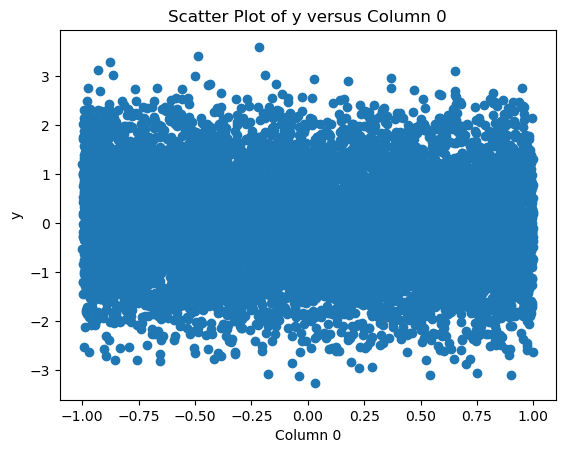

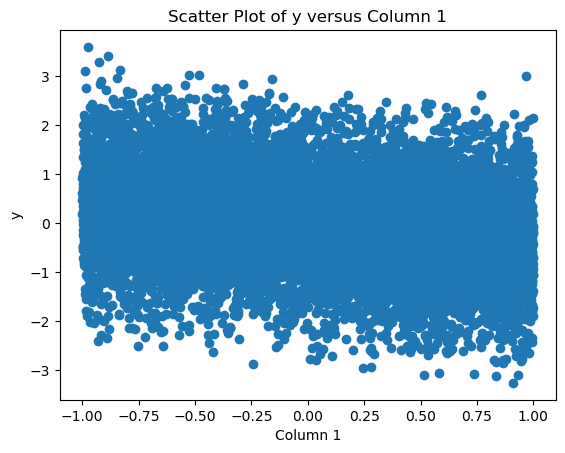

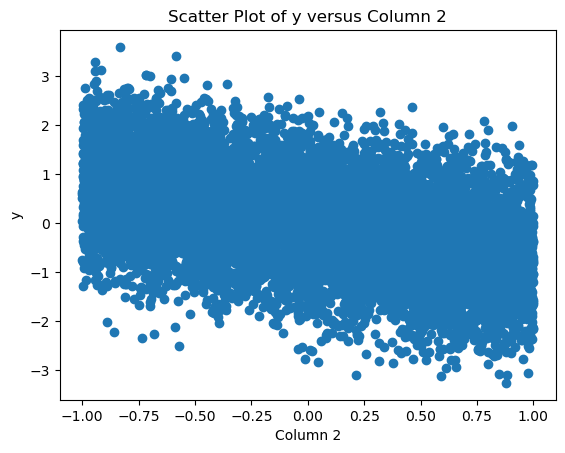

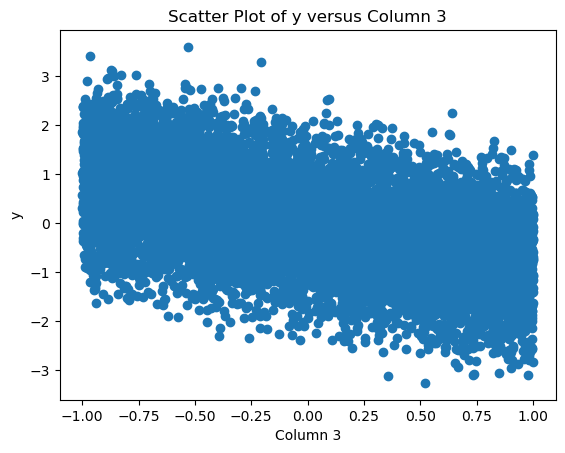

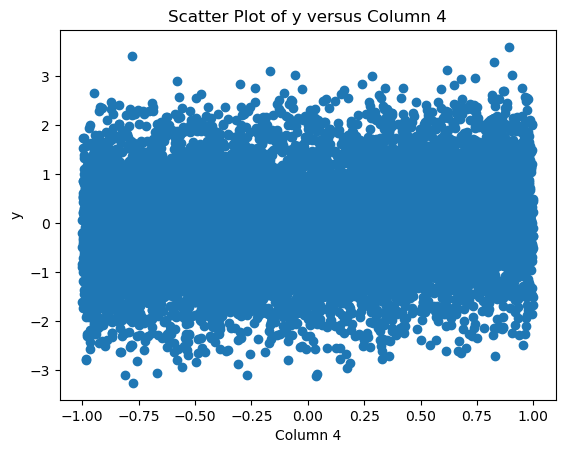

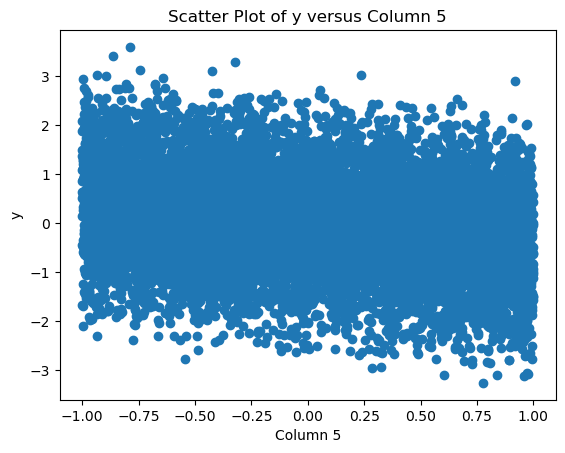

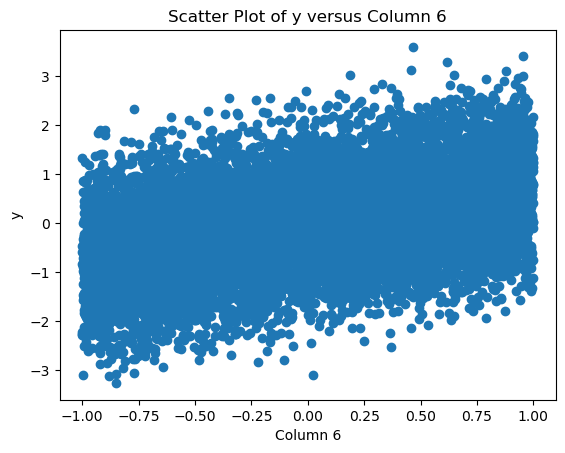

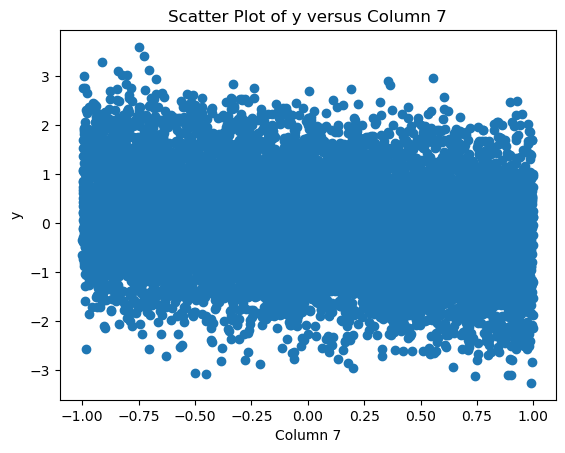

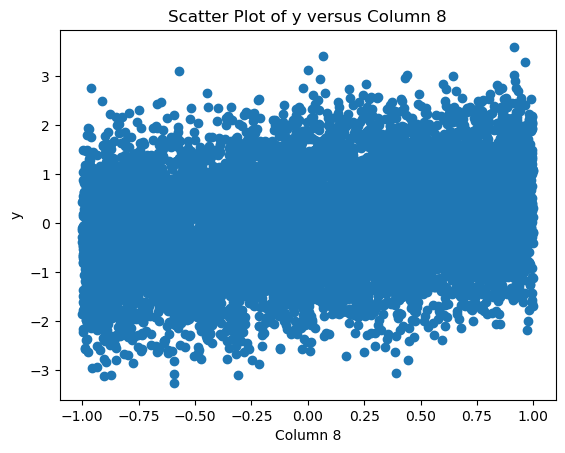

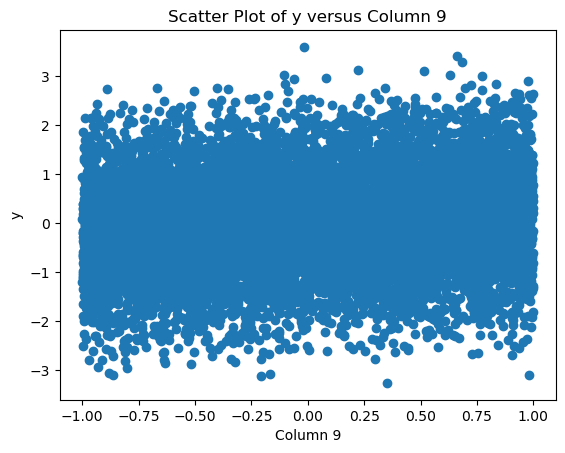

In [3]:
import matplotlib.pyplot as plt

for i in range(Ndims):
    plt.scatter(samples[:, i], y)
    plt.xlabel('Column {}'.format(i))
    plt.ylabel('y')
    plt.title('Scatter Plot of y versus Column {}'.format(i))
    plt.show()


In [4]:
# Create a custom Pytorch data set
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomRegressionDataset(Dataset):
    def __init__(self, filename, transform=None, target_transform=None):
        self.dataset = torch.from_numpy(np.loadtxt(filename, delimiter=',')).float()
        self.transform = transform
        self.target_transform = target_transform

    # The __len__ method returns the number of samples in our dataset.
    def __len__(self):
        return len(self.dataset)

    # The __getitem__ method loads and returns a sample from the dataset at the given index idx.
    def __getitem__(self, idx):
        x = self.dataset[idx, :-1]
        y = self.dataset[idx, -1]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y
    

/local/anaconda3/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from torch.utils.data import DataLoader

training_data = CustomRegressionDataset('data.csv')
test_data = CustomRegressionDataset('testdata.csv')
print(training_data[0])
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(5):
    print(train_features[i], train_labels[i])


(tensor([-0.4760, -0.6826, -0.4437, -0.0814, -0.3580,  0.0368, -0.4761,  0.9522,
         0.4656, -0.7695]), tensor(0.0949))
Feature batch shape: torch.Size([64, 10])
Labels batch shape: torch.Size([64])
tensor([-0.3464,  0.5143, -0.0207, -0.3444,  0.7564, -0.6211,  0.9720,  0.7896,
        -0.0878,  0.5804]) tensor(0.9561)
tensor([ 0.8842,  0.2201,  0.7191,  0.6755, -0.4897,  0.2985, -0.3037, -0.5613,
         0.3916,  0.8989]) tensor(-1.1702)
tensor([-0.3938,  0.1928,  0.3999, -0.1900, -0.7011, -0.8637, -0.2425,  0.7056,
        -0.6985,  0.3976]) tensor(-0.6270)
tensor([ 0.9286,  0.6778,  0.9999,  0.2322,  0.8283,  0.4461,  0.9986, -0.5212,
        -0.5598, -0.4075]) tensor(-0.7419)
tensor([-0.3904,  0.9286, -0.0925,  0.9293, -0.4285, -0.1565, -0.9112, -0.8491,
        -0.6048,  0.3741]) tensor(-1.5767)


In [6]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(Ndims, 1, bias=False)

    def forward(self, x):
        y = self.linear(x)
        return y

model = NeuralNetwork()

In [7]:
learning_rate = 1e-3
#batch_size = batch_size
epochs = 50

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# loops over our optimization code
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [9]:
# evaluate the model's performance against the test dataset
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, sum_of_residuals = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()
            residuals = ((pred.squeeze()-y)**2).sum()
            sum_of_residuals += residuals

    test_loss /= num_batches
    sum_of_residuals /= size
    print(f"Test Error: \n sum_of_residuals: {sum_of_residuals:>6f}, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [10]:
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")


Epoch 1
-------------------------------
loss: 1.034357  [   64/10000]
loss: 0.861390  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.882844, Avg loss: 0.872755 

Epoch 2
-------------------------------
loss: 0.940621  [   64/10000]
loss: 0.803140  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.716210, Avg loss: 0.712772 

Epoch 3
-------------------------------
loss: 0.975802  [   64/10000]
loss: 0.559452  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.581162, Avg loss: 0.582331 

Epoch 4
-------------------------------
loss: 0.614643  [   64/10000]
loss: 0.556095  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.472142, Avg loss: 0.469817 

Epoch 5
-------------------------------
loss: 0.518375  [   64/10000]
loss: 0.425420  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.383514, Avg loss: 0.383944 

Epoch 6
-------------------------------
loss: 0.377242  [   64/10000]
loss: 0.317189  [ 6464/10000]
Test Error: 
 sum_of_residuals: 0.312033, Avg loss: 0.310592 

Epoch 7
--------------

Parameter name: linear.weight, Size: torch.Size([1, 10]), Values: Parameter containing:
tensor([[-0.1296, -0.4699, -0.8346, -0.9067,  0.2141, -0.4437,  0.7581, -0.3786,
          0.4728,  0.2575]], requires_grad=True)


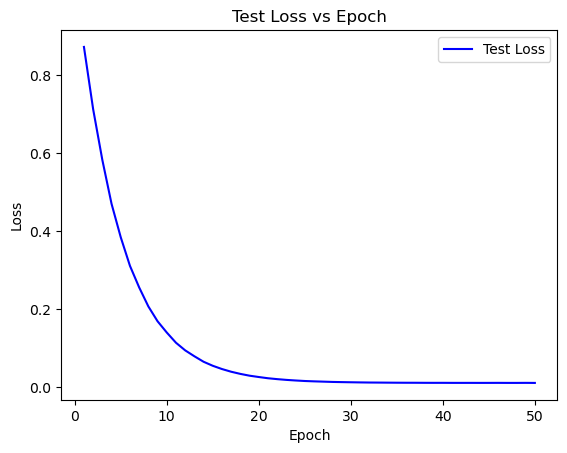

In [11]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}, Values: {param}")

import matplotlib.pyplot as plt
# Assuming you have the `test_loss` variable containing the loss values for each epoch
epochs = range(1, len(test_loss) + 1)
plt.plot(epochs, test_loss, 'b', label='Test Loss')
plt.title('Test Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


[-0.20844157 -0.01990945 -0.40137071  0.78827216 -0.5637662  -0.43809951
  0.06942724 -0.42388217  0.67011775 -0.38448952] tensor([0.1613], grad_fn=<SelectBackward0>)
[ 0.21297212  0.2180138  -0.48506257 -0.65816225 -0.35284083  0.23199536
 -0.31447228  0.75962416 -0.06283751  0.90275227] tensor([0.3699], grad_fn=<SelectBackward0>)
[ 0.89388199  0.39677418 -0.29810766  0.18778021 -0.0712582   0.16236638
  0.07567704  0.23333949  0.38174458  0.88593787] tensor([0.0666], grad_fn=<SelectBackward0>)
[ 0.06385781  0.60629238 -0.57709994  0.06725507 -0.96929523  0.75371593
 -0.51456073  0.31979613  0.73002053  0.65735687] tensor([-0.4111], grad_fn=<SelectBackward0>)
[-0.10621775  0.87271563 -0.47656511  0.06136587 -0.3680371   0.42828011
 -0.55395683 -0.71258718  0.01635416  0.44633298] tensor([-0.3505], grad_fn=<SelectBackward0>)


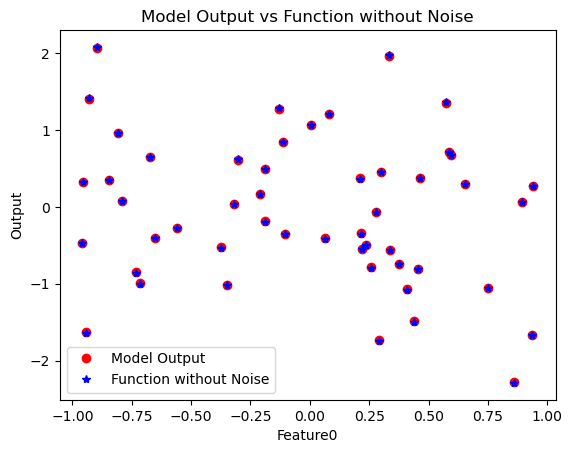

In [12]:
array = np.random.uniform(-1,1,size=(50, Ndims))
model.eval()
output = model(torch.tensor(array).float())
function_without_noise = np.zeros(50)
for i, x in enumerate(array):
    function_without_noise[i] = np.sum(coefficients*x)
#print(function_without_noise)
for i in range(5):
    print(array[i], output[i])
plt.plot(array[:,0], output.detach().numpy(), 'ro', label='Model Output')
plt.plot(array[:,0], function_without_noise, 'b*', label='Function without Noise')
plt.xlabel('Feature0')
plt.ylabel('Output')
plt.title('Model Output vs Function without Noise')
plt.legend()
plt.show()